In [1]:
import numpy as np
from math import exp, sqrt, ceil, log, floor
from matplotlib import pyplot as plt

In [2]:
def numerov(n, l, nmax = -1, rCore=0.65):
    """
    Calculate radial integral for given state using numerov approach.
    n: Principle quantum number
    l: Azimuthal quantum number
    """
    if  l>=n:
        raise ValueError("Error: Azimuthal quantum number should be less than principle quantum number")
    if nmax == -1:
        nmax = n
    
    # Function for calculating g(x)
    g_func = lambda r: 2* r**2 * (-1.0/r - w) + (l + 0.5)**2

    h = 0.01 # Step Size
    w = -0.5 *float(n)**-2 # Energy

    # First starting point Y_{-1}  
    rMax = 2 * nmax * (nmax + 15)
    if n == nmax: # Align wavefunctions using grid defined by max n in calculation
        i = 2 # Numerov approach starts at third point in itteration
        iStart = i - 2
        rStart1 = rMax
    else:
        i = int(floor(log(rMax / (2 * n * (n + 15))) / h))
        iStart = i 
        rStart1 = rMax * exp(-i*h)
        i = i+2
    yStart1 = 1e-10

    # Secound starting point Y_{0}
    rStart2 = rStart1 * exp(-h)
    yStart2 = yStart1 * (1 + h*sqrt(g_func(rStart1)))

    # Define integration end points:
    rCore = 0.191**(1/3) # Core polarisability (specific to each atom species)
    rFugal = n**2 - n * sqrt(n**2 - l*(l+1)) # Inner turning point

    # Numerov Method: Need to figure out the number itterations that will be included in the integartion.
    ri = rStart1 * exp(-h*2)

    # Prepare arrays
    lengthMax = int(ceil(log(rMax/rCore)/h))
    r = np.zeros(lengthMax) 
    y = np.zeros(lengthMax)
    r[i-2] = rStart1
    r[i-1] = rStart2
    y[i-2] = yStart1
    y[i-1] = yStart2

    while (ri > rCore):
        r[i] = ri

        A = y[i-2]*(g_func(r[i-2]) - 12/h**2)
        B = y[i-1]*(10*g_func(r[i-1]) + 24/h**2)
        C = 12/h**2 - g_func(r[i])

        y[i] = ((A + B)/C)
        
        if (ri < rFugal):
            # Check for divergence
            dy = abs((y[i] - y[i-1]) / y[i-1])
            dr = (r[i]**(-l-1) - r[i-1]**(-l-1))/(r[i-1]**(-l-1))
            if dy>dr:
                break


        i += 1
        ri = ri * exp(-h)
    iEnd = i



    return {'data': {'r':r, 'y': y},  'steps': {"start": iStart, 'end': iEnd}}

wf = numerov(19, 0)

In [ ]:
def numerov_calc_matrix_element(wf1, wf2):
    """
    Calculate the radial component of the transition matrix element.
    Accepts two numrov integration data sets as tuples.
    """

    # Find range of points for which there are values for both wavefunctions
    iStart = max(wf1['steps']['start'], wf2['steps']['start']) # This does not work!!
    iEnd   = min(wf1['steps']['end'], wf2['steps']['end'])

    y1 = wf1['data']['y'][iStart:iEnd]
    y2 = wf2['data']['y'][iStart:iEnd]
    r = wf1['data']['r'][iStart:iEnd]


    # Calculate matrix element 
    M = np.sum(y1 * y2 * r**3)

    # Normalise
    norm1 = (np.sum(wf1['data']['y']**2 * wf1['data']['r']**2))
    norm2 = (np.sum(wf2['data']['y']**2 * wf2['data']['r']**2))

    M = M/sqrt(norm1 * norm2)
    return M


12.313970608213603

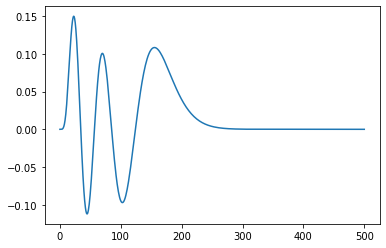

In [ ]:
wf = numerov(10, 5)
plt.plot(wf['data']['r'], wf['data']['y'])
sum(wf['data']['y'])

In [75]:
wf1 = numerov(19, 1, 19)
wf2 = numerov(13, 0, 19)

numerov_calc_matrix_element(wf1, wf2)

-0.0007121908004236212


-5.260719608403822

In [77]:
wf1['data']['y'][1]

1.451912602169933e-10

In [15]:
def gen_matrix_empty(nmin, nmax):
    """
    Generate zero matrix of mm[n][l][n'][l']
    output is a nested dictionary
    """
    nn = np.arange(nmin, nmax+1, 1)
    mm = {}
    for a in nn:
        l1 = np.arange(0,a)
        m1 = {}
        for b in l1:   
            m2 = {}
            for c in nn:
                l2 = np.arange(0,c)
                m3 = {}
                for d in l2:
                    m3[d] = 0
                m2[c] = m3
            m1[b] = m2
        mm[a] = m1
    return mm

def gen_matrix_H0(nmin, nmax):
    mm = gen_matrix_empty(nmin, nmax)
    for i in mm.keys():
        for j in mm[i].keys():
            mm[i][j][i][j] = -0.5 * (i - get_qd(i,j))**(-2)
    return make_array(mm)

def gen_matrix_Hs(nmin, nmax):
    m = 0

    mm = gen_matrix_empty(nmin, nmax)
    elems = []
    for i in range(nmax-1):
        elem = (i, i+1)
        elems.append(elem)

    for elem in elems:
        l1 = elem[0] 
        l2 = elem[1]

        for i in mm.keys(): # n1
            if l1 < i:
                ns1 = i - get_qd(i, l1)
                wf1 = numerov(ns1, l1, nmax)
                
                for j in mm[i][l1].keys():
                    if l2 < j:
                        ns2 = j - get_qd(j, l2)
                        wf2 = numerov(ns2, l2, nmax)
                        radialInt = numerov_calc_matrix_element(wf1, wf2)

                        try:
                            test = mm[i][l1][j][l2] # Check for entry
                            angularElem = ((l1 + 1)**2 - m**2)/((2*l1+3)*(2*l1+1))
                            angularElem = sqrt(angularElem)
                            mm[i][l1][j][l2] = radialInt * angularElem
                        except KeyError:
                            pass
                        
                        try:
                            test = mm[j][l2][i][l1]
                            
                            angularElem = (l2**2 - m**2)/((2*l2+1)*(2*l2-1))
                            angularElem = sqrt(angularElem)
                            mm[j][l2][i][l1] = radialInt * angularElem
                        except KeyError:
                            pass
    
    return make_array(mm)

def get_qd(n, l):
    qd = {0: 0.3996, 1:0.0539, 2:0.002}
    if l in qd:
        return qd[l]
    else:
        return float(0)

def make_array(mm):
    size = sum(np.arange(min(mm.keys()), max(mm.keys())+1, 1))
    
    m = np.empty((size,size))
    i = 0
    j = 0

    for a in mm.keys():
        for b in mm[a].keys():
            for c in mm[a][b].keys():
                for d in mm[a][b][c].keys():
                    m[i][j] = mm[a][b][c][d]
                    j += 1    
            j = 0   
            i += 1
            

    return m 

Need to calcualte quantum defects:

In [16]:
nmin = 13
nmax = 21
m0 = gen_matrix_H0(nmin, nmax)
mH = gen_matrix_Hs(nmin, nmax)

In [17]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df = pd.DataFrame(mH)
df.head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152
0,0.000000,125.110390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.648818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.032627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.332075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.046104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
1,125.110390,0.000000,129.250207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.195383,0.000000,29.631116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.565367,0.000000,-11.887789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.935933,0.000000,6.905587,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.352619,0.000000,2.263690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.940416,0.000000,-1.907051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
2,0.000000,129.250207,0.000000,125.106514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.205011,0.000000,39.486234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.503602,0.000000,-14.892091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.651623,0.000000,8.455501,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.644516,0.000000,2.689055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1.365684,0.000000,-2.257898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
3,0.000000,0.000000,125.106514,0.000000,121.554196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.846884,0.000000,43.175359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.608014,0.000000,-16.241254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.104759,0.000000,9.202302,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.177762,0.000000,2.907328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.974923,0.000000,-2.438205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
4,0.000000,0.000000,0.000000,121.554196,0.000000,117.58

In [18]:
print (np.concatenate(mH).sum())


79544.97816003118


In [19]:
m_e = 9.10938356e-31
Ry = 10973731.568508
c = 299792458.0 ## speed of light in vacuum
h = 6.626070040e-34
hbar = 1.054571800e-34
e = 1.6021766208e-19
alpha = 7.2973525664e-3
m_u = 1.660539040e-27


A_r_He = 6.941 #Lithium
ionization_He = 4348715.0 #lithium

mass_He = A_r_He * m_u # Mass of lithium
mass_He_core = mass_He - m_e + ionization_He * h /c
mu_me = mass_He_core / (mass_He_core + m_e)
Ry_He = Ry * mu_me

En_h_He = 2*Ry_He*h*c

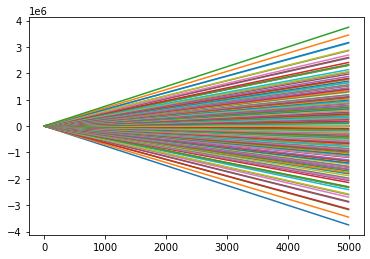

In [20]:
field = np.linspace(0, 5000, 1000) # V /cm

vals = []

for f in field:

    val = np.linalg.eigh(m0 + f*mH)[0]
    vals.append(val)
plt.plot(field, vals)


# Now with the correct scaling:

In [21]:
mass_He_core

1.152489054789561e-26

In [22]:
#CODATA 2014, DOI: 10.1103/RevModPhys.88.035009
c = 299792458.0 ## speed of light in vacuum
h = 6.626070040e-34
hbar = 1.054571800e-34
Ry = 10973731.568508
e = 1.6021766208e-19
m_e = 9.10938356e-31
alpha = 7.2973525664e-3
amu = 1.660539040e-27 # Kg   (NIST) unified atomic mass unit 
En_h = alpha**2.0 * m_e * c**2.0
a_0 = hbar/ (m_e * c * alpha)
mu_B = e * hbar / (2.0 * m_e)




A_r_He = 6.941 #Lithium
ionization_He = 4348715.0 #lithium

mass_He = A_r_He * m_u # Mass of lithium
mass_He_core = mass_He - m_e + ionization_He * h /c
mu_me = mass_He_core / (mass_He_core + m_e)
Ry_He = Ry * mu_me

En_h_He = 2*Ry_He*h*c

Ry = 10973731.568508
# Lithium
mLi = 6.941*amu
mLiIon = mLi - m_e
reducedMass = (mLiIon * m_e)/(mLiIon+m_e)


a_Li  = (a_0*m_e)/reducedMass

R_Li = Ry * reducedMass/m_e
E_Li = 2*h*c*R_Li

F_Li = E_Li/a_Li

In [23]:
field = np.linspace(0, 600000, 1000) # V /m

vals = []

E_Li = 2*h*c*R_Li

F_Li = E_Li/(a_Li*e) # amu convertion factor

for f in field:
    fau = f / F_Li 
    val = (np.linalg.eigh(m0 + mH*fau)[0]*E_Li)/(h*c*100)
    vals.append(val)



(-540.0, -440.0)

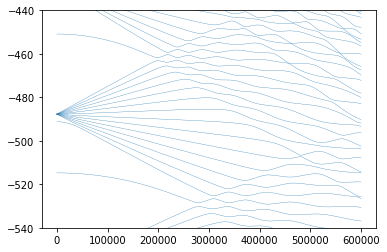

In [24]:
plt.plot(field, vals, c='tab:blue', linewidth=0.3)
plt.ylim([-540, -440])

In [25]:
mH*E_Li*e + m0

array([[-3.14920796e-03,  8.73837134e-35,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.73837134e-35, -2.98326676e-03,  9.02751804e-35, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.02751804e-35, -2.95949042e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.13378685e-03,  9.84267508e-35,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.84267508e-35, -1.13378685e-03,  7.04604444e-35],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  7.04604444e-35, -1.13378685e-03]])

In [26]:
F_Li = E_Li/(a_Li*e)
F_Li/10**11

5.141393915413142

In [27]:
R_Li/10**5

109.7286426283607

In [28]:
reducedMass

9.108663602528829e-31

In [29]:
m_e

9.10938356e-31

In [30]:
Ry/10**5

109.73731568507999

In [31]:
E_Li

4.359400078822846e-18

In [32]:
e

1.6021766208e-19

In [33]:
import pandas as pd
df = pd.DataFrame(mH)
df[1][0]

125.11039010050189